In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import time
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad, lax
from jax.tree_util import tree_map
import jax
import jaxlib
import pandas as pd
import optax
from itertools import chain

import jaxley as jx
from jaxley.channels import Leak
from jaxley_mech.channels.l5pc import *
from jaxley.optimize.utils import l2_norm

In [4]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"optax {optax.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.29
jaxlib 0.4.28
pandas 2.2.1
optax 0.2.2
numpy 1.26.4


In [5]:
def sample_within(n, bounds):
    return jnp.asarray(np.random.rand(n) * (bounds[1] - bounds[0]) + bounds[0])

In [6]:
bounds = {}
gt_apical = {}
gt_soma = {}
gt_axon = {}

bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
gt_apical["apical_NaTs2T_gNaTs2T"] = 0.026145

bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
gt_apical["apical_SKv3_1_gSKv3_1"] = 0.004226

bounds["apical_M_gM"] = [0, 0.001]
gt_apical["apical_M_gM"] = 0.000143

bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 1.0]
gt_soma["somatic_NaTs2T_gNaTs2T"] = 0.983955

bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
gt_soma["somatic_SKv3_1_gSKv3_1"] = 0.303472

bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
gt_soma["somatic_SKE2_gSKE2"] = 0.008407

bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
gt_soma["somatic_CaPump_gamma"] = 0.000609

bounds["somatic_CaPump_decay"] = [20, 1_000]
gt_soma["somatic_CaPump_decay"] = 210.485291

bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
gt_soma["somatic_CaHVA_gCaHVA"] = 0.000994

bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
gt_soma["somatic_CaLVA_gCaLVA"] = 0.000333

bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
gt_axon["axonal_NaTaT_gNaTaT"] = 3.137968

bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
gt_axon["axonal_KPst_gKPst"] = 0.973538

bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
gt_axon["axonal_KTst_gKTst"] = 0.089259

bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
gt_axon["axonal_SKE2_gSKE2"] = 0.007104

bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]  # [0, 2.0]
gt_axon["axonal_SKv3_1_gSKv3_1"] = 1.021945

bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]  # 0.001
gt_axon["axonal_CaHVA_gCaHVA"] = 0.00099

bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]  # 0.01
gt_axon["axonal_CaLVA_gCaLVA"] = 0.008752

bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]  # [0.0005,0.05]
gt_axon["axonal_CaPump_gamma"] = 0.00291

bounds["axonal_CaPump_decay"] = [20, 1_000]
gt_axon["axonal_CaPump_decay"] = 287.19873

In [7]:
nseg = 4
cell = jx.read_swc("../morphologies/bbp_with_axon.swc", nseg=nseg, max_branch_len=300.0, assign_groups=True)

soma_inds = np.unique(cell.group_nodes["soma"].branch_index).tolist()
apical_inds = np.unique(cell.group_nodes["apical"].branch_index).tolist()
basal_inds = np.unique(cell.group_nodes["basal"].branch_index).tolist()
axonal_inds = np.unique(cell.group_nodes["axon"].branch_index).tolist()

########## APICAL ##########
cell.apical.set("capacitance", 2.0)
cell.apical.insert(NaTs2T().change_name("apical_NaTs2T"))
cell.apical.insert(SKv3_1().change_name("apical_SKv3_1"))
cell.apical.insert(M().change_name("apical_M"))
cell.apical.insert(H().change_name("apical_H"))
for b in apical_inds:
    for c in [0.125, 0.375, 0.625, 0.875]:
        distance = cell.branch(b).loc(c).distance(cell.branch(0).loc(0.0))
        cond = (-0.8696 + 2.087* np.exp(distance*0.0031)) * 8e-5
        cell.branch(b).loc(c).set("apical_H_gH", cond)

########## SOMA ##########
cell.soma.insert(NaTs2T().change_name("somatic_NaTs2T"))
cell.soma.insert(SKv3_1().change_name("somatic_SKv3_1"))
cell.soma.insert(SKE2().change_name("somatic_SKE2"))
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump().change_name("somatic_CaPump"))
cell.soma.insert(CaHVA().change_name("somatic_CaHVA"))
cell.soma.insert(CaLVA().change_name("somatic_CaLVA"))
cell.soma.set("CaCon_i", 5e-05)
cell.soma.set("CaCon_e", 2.0)

########## BASAL ##########
cell.basal.insert(H().change_name("basal_H"))
cell.basal.set("basal_H_gH", 8e-5)

# ########## AXON ##########
cell.insert(CaNernstReversal())
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)

cell.axon.insert(NaTaT().change_name("axonal_NaTaT"))
cell.axon.set("axonal_NaTaT_gNaTaT", 3.137968)

cell.axon.insert(KTst().change_name("axonal_KTst"))
cell.axon.set("axonal_KTst_gKTst", 0.089259)

cell.axon.insert(CaPump().change_name("axonal_CaPump"))
cell.axon.set("axonal_CaPump_gamma", 0.00291)
cell.axon.set("axonal_CaPump_decay", 287.19873)

cell.axon.insert(SKE2().change_name("axonal_SKE2"))
cell.axon.set("axonal_SKE2_gSKE2", 0.007104)

cell.axon.insert(CaHVA().change_name("axonal_CaHVA"))
cell.axon.set("axonal_CaHVA_gCaHVA", 0.00099)

cell.axon.insert(KPst().change_name("axonal_KPst"))
cell.axon.set("axonal_KPst_gKPst", 0.973538)

cell.axon.insert(SKv3_1().change_name("axonal_SKv3_1"))
cell.axon.set("axonal_SKv3_1_gSKv3_1", 1.021945)

cell.axon.insert(CaLVA().change_name("axonal_CaLVA"))
cell.axon.set("axonal_CaLVA_gCaLVA", 0.008752)


########## WHOLE CELL  ##########
cell.insert(Leak())
cell.set("Leak_gLeak", 3e-05)
cell.set("Leak_eLeak", -75.0)

cell.set("axial_resistivity", 100.0)
cell.set("eNa", 50.0)
cell.set("eK", -85.0)
cell.set("v", -65.0)

In [37]:
res = 100
sigma = 400

evals = np.linspace(0, 1200, res)
kernel = np.zeros((res, res))
for ind_i, i in enumerate(evals):
    for ind_j, j in enumerate(evals):
        d = (i - j)**2
        kernel[ind_i, ind_j] = np.exp(-d / sigma**2)

def softplus(x):
    return np.log(1 + np.exp(x))

def inv_softplus(x: jnp.ndarray):
    """Inverse softplus."""
    return np.log(np.exp(x) - 1)

def sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    """Sigmoid."""
    return 1 / (1 + jnp.exp(-1.5*x))

def expit(x: jnp.ndarray) -> jnp.ndarray:
    """Inverse sigmoid (expit)"""
    return -jnp.log(1 / x - 1)

def gaussian_cdf(x):
    return jax.scipy.stats.norm.cdf(x)

def sample_profile():
    profile = np.random.multivariate_normal(np.zeros((res)), kernel)
    return gaussian_cdf(profile) * 0.8 + 0.1

# For every parameter, sample the ground truth parameter function.
np.random.seed(2)
gt_profiles_apical = {}
gt_profiles_apical["apical_NaTs2T_gNaTs2T"] = sample_profile()
gt_profiles_apical["apical_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_apical["apical_M_gM"] = sample_profile()

np.random.seed(22)
gt_profiles_axonal = {}
gt_profiles_axonal["axonal_NaTaT_gNaTaT"] = sample_profile()
gt_profiles_axonal["axonal_KPst_gKPst"] = sample_profile()
gt_profiles_axonal["axonal_KTst_gKTst"] = sample_profile()
gt_profiles_axonal["axonal_SKE2_gSKE2"] = sample_profile()
gt_profiles_axonal["axonal_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_axonal["axonal_CaHVA_gCaHVA"] = sample_profile()
gt_profiles_axonal["axonal_CaLVA_gCaLVA"] = sample_profile()

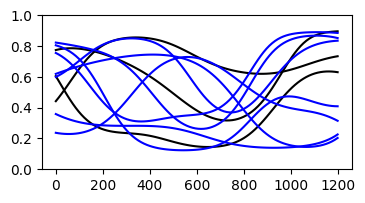

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
counter = 0
for item in gt_profiles_apical.values():
    if counter < 3:
        _ = ax.plot(evals, item, c="k")
    counter += 1
for item in gt_profiles_axonal.values():
    _ = ax.plot(evals, item, c="b")
_ = ax.set_ylim([0, 1])
plt.show()

In [39]:
# Apical.
for b in apical_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_apical.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_soma.keys():
    cell.soma.set(key, gt_soma[key])

for b in axonal_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_axonal.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_axon.keys():
    cell.axon.set(key, gt_axon[key])

In [40]:
cell.delete_trainables()

for key in gt_profiles_apical.keys():
    cell.branch(apical_inds).make_trainable(key)

for key in gt_soma.keys():
    cell.soma.make_trainable(key)

for key in gt_profiles_axonal.keys():
    cell.branch(axonal_inds).make_trainable(key)

cell.axon.make_trainable("axonal_CaPump_gamma")
cell.axon.make_trainable("axonal_CaPump_decay")

parameters = cell.get_parameters()

Number of newly added trainable parameters: 129. Total number of trainable parameters: 129
Number of newly added trainable parameters: 129. Total number of trainable parameters: 258
Number of newly added trainable parameters: 129. Total number of trainable parameters: 387
Number of newly added trainable parameters: 1. Total number of trainable parameters: 388
Number of newly added trainable parameters: 1. Total number of trainable parameters: 389
Number of newly added trainable parameters: 1. Total number of trainable parameters: 390
Number of newly added trainable parameters: 1. Total number of trainable parameters: 391
Number of newly added trainable parameters: 1. Total number of trainable parameters: 392
Number of newly added trainable parameters: 1. Total number of trainable parameters: 393
Number of newly added trainable parameters: 1. Total number of trainable parameters: 394
Number of newly added trainable parameters: 142. Total number of trainable parameters: 536
Number of new

In [41]:
repeats = {
    "apical_NaTs2T_gNaTs2T": len(apical_inds),
    "apical_SKv3_1_gSKv3_1": len(apical_inds),
    "apical_M_gM": len(apical_inds), 
    "somatic_NaTs2T_gNaTs2T": 1,
    "somatic_SKv3_1_gSKv3_1": 1,
    "somatic_SKE2_gSKE2": 1,
    "somatic_CaHVA_gCaHVA": 1,
    "somatic_CaLVA_gCaLVA": 1,
    "somatic_CaPump_gamma": 1,
    "somatic_CaPump_decay": 1,
    "axonal_NaTaT_gNaTaT": len(axonal_inds),
    "axonal_KPst_gKPst": len(axonal_inds),
    "axonal_KTst_gKTst": len(axonal_inds),
    "axonal_SKE2_gSKE2": len(axonal_inds),
    "axonal_SKv3_1_gSKv3_1": len(axonal_inds),
    "axonal_CaHVA_gCaHVA": len(axonal_inds),
    "axonal_CaLVA_gCaLVA": len(axonal_inds),
    "axonal_CaPump_gamma": 1,
    "axonal_CaPump_decay": 1,
}
num_params = sum(list(repeats.values()))
print(f"Total number of parameters: {num_params}")

Total number of parameters: 1390


In [42]:
with open("../results/03_voltage_imaging/cell.pkl", "wb") as handle:
    pickle.dump(cell, handle)

with open("../results/03_voltage_imaging/profile_evals.pkl", "wb") as handle:
    pickle.dump(evals, handle)
    
with open("../results/03_voltage_imaging/axonal_profile.pkl", "wb") as handle:
    pickle.dump(gt_profiles_axonal, handle)

with open("../results/03_voltage_imaging/apical_profile.pkl", "wb") as handle:
    pickle.dump(gt_profiles_apical, handle)

with open("../results/03_voltage_imaging/bounds.pkl", "wb") as handle:
    pickle.dump(bounds, handle)

In [43]:
dt = 0.025
t_max = 5.0
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 0.0
i_dur = 3.0
i_amp = 3.0
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(soma_inds[0]).loc(0.0).stimulate(current)  # Stimulate soma
cell[range(0,339,1),0].record()
# cell.record()

cell.set("v", -70.0)
cell.init_states()

Added 1 external_states. See `.externals` for details.
Added 339 recordings. See `.recordings` for details.


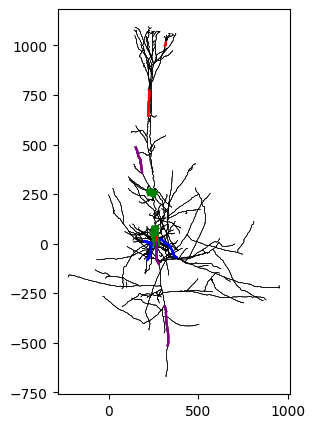

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
_ = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.3})
_ = cell[[13, 215, 230]].vis(ax=ax, col="g", morph_plot_kwargs={"linewidth": 5.0})  # Proximal apical
_ = cell[[1, 270, 290]].vis(ax=ax, col="r")  # Distal apical
_ = cell[[165, 170, 185]].vis(ax=ax, col="b")  # Basal
_ = cell[[2, 53, 93]].vis(ax=ax, col="purple")  # Axonal
plt.show()

In [45]:
def simulate(params):
    return jx.integrate(cell, params=params)

jitted_sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(0,)))

def sim_gt():
    return jx.integrate(cell)

jitted_sim_gt = jit(sim_gt)

In [46]:
blues = [
    "#74a9cf",
    "#3690c0",
    "#0570b0",
]
reds = [
    "#fc8d59",
    "#ef6548",
    "#d7301f",
]
greens = [
    "#66c2a4",
    "#41ae76",
    "#238b45",
]
grays = [
    "#969696",
    "#737373",
    "#525252",
]
cols = greens + reds + blues + grays

### Seed 0

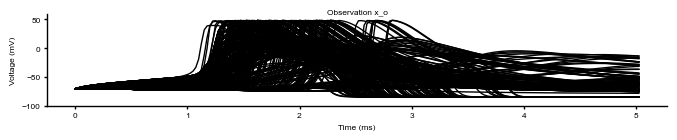

In [47]:
x_o = jitted_sim_gt()
    
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 1.2))
    for i in range(len(x_o)):
        _ = ax.plot(time_vec, x_o[i], c="k")  #, c=cols[i])
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()

In [48]:
with open("../results/03_voltage_imaging/recording_xo.pkl", "wb") as handle:
    pickle.dump(x_o, handle)

### Define loss

In [49]:
def loss_from_v(v):
    return jnp.mean(jnp.abs(v[:, 40:200:5] - x_o[:, 40:200:5]))

vmapped_loss_from_v = vmap(loss_from_v, in_axes=(0,))

In [50]:
def build_regularizer(inds):
    parents = cell.comb_parents
    apical_inds_from_zero = np.arange(len(inds))
    
    parents_of_apical = np.asarray(parents)[np.asarray(inds)]
    parent_is_also_apical = np.asarray([p in np.asarray(inds) for p in parents_of_apical])
    apical_inds_from_zero = apical_inds_from_zero[parent_is_also_apical]
    
    parents_of_apical = parents_of_apical[parent_is_also_apical]
    parents_from_zero = np.asarray([np.where(inds == p)[0][0] for p in parents_of_apical])
    
    return apical_inds_from_zero, parents_from_zero

In [51]:
param_child_apical, param_parent_apical = build_regularizer(apical_inds)
param_child_axonal, param_parent_axonal = build_regularizer(axonal_inds)

# Gradient descent

In [52]:
def loss_fn(opt_params):
    params = transform.forward(opt_params)
    vs = simulate(params)
    loss = loss_from_v(vs)
    reg = regularizer(opt_params)
    return 1.0 * loss + 0.001 * reg

def regularizer(opt_params):
    reg_apical = 0.0
    reg_axonal = 0.0
    for key, i in zip(gt_profiles_apical, [0, 1, 2]):
        reg_apical += jnp.sum((opt_params[i][key][param_child_apical] - opt_params[i][key][param_parent_apical])**2)
    for key, i in zip(gt_profiles_axonal, np.arange(10, 20)):
        reg_axonal += jnp.sum((opt_params[i][key][param_child_axonal] - opt_params[i][key][param_parent_axonal])**2)
    return reg_apical + reg_axonal

jitted_loss_fn = jit(loss_fn)
grad_fn = jit(value_and_grad(loss_fn))

In [53]:
lowers = {}
uppers = {}
for key in bounds:
    lowers[key] = bounds[key][0]
    uppers[key] = bounds[key][1]

transform = jx.ParamTransform(
    lowers=lowers,
    uppers=uppers,
)

In [54]:
# set = init()
start_time = time.time()
opt_params = transform.inverse(parameters)
l = jitted_loss_fn(opt_params)
print("Time", time.time() - start_time)

Time 27.521365880966187


In [55]:
desired_loss = 1.0

In [56]:
start_time = time.time()
loss_val, grad_val = grad_fn(opt_params)
print("Time", time.time() - start_time)

Time 123.94255304336548


In [57]:
def init():
    for i in range(len(opt_params)):
        key = list(opt_params[i].keys())[0]
        rands = 2.0 * np.random.randn(*(opt_params[i][key].shape))
        opt_params[i][key] = jnp.asarray(rands)
    return opt_params

loss in epoch 0: 30.7849, gradient_norm 5.8109, corrected 1.4218
loss in epoch 5: 19.8353, gradient_norm 4.3631, corrected 1.3426
loss in epoch 10: 15.2440, gradient_norm 0.9526, corrected 0.9903
loss in epoch 15: 13.7245, gradient_norm 0.5097, corrected 0.8739
loss in epoch 20: 12.6416, gradient_norm 0.4263, corrected 0.8432
loss in epoch 25: 11.5033, gradient_norm 0.4023, corrected 0.8335
loss in epoch 30: 10.2619, gradient_norm 0.3810, corrected 0.8245
loss in epoch 35: 8.9902, gradient_norm 0.3421, corrected 0.8069
loss in epoch 40: 7.8283, gradient_norm 0.3079, corrected 0.7901
loss in epoch 45: 6.7861, gradient_norm 0.2864, corrected 0.7788
loss in epoch 50: 5.8495, gradient_norm 0.2482, corrected 0.7567
loss in epoch 55: 5.0501, gradient_norm 0.2216, corrected 0.7398
loss in epoch 60: 4.3325, gradient_norm 0.1987, corrected 0.7238
loss in epoch 65: 3.6940, gradient_norm 0.1908, corrected 0.7180
loss in epoch 70: 3.1492, gradient_norm 0.1812, corrected 0.7106
loss in epoch 75: 2.

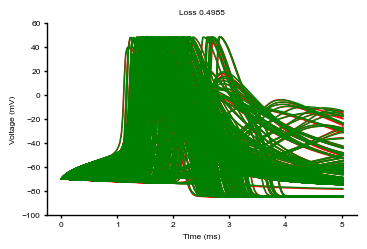

seed 1 ===== Best loss 0.4985453572831774


In [58]:
losses_of_every_starting_point = []
best_traces = []
best_losses = []
all_best_params = []
total_sims = 0
beta = 0.8

for seed in np.arange(1, 2, 25):
    _ = np.random.seed(seed)

    opt_params = init()

    train_losses = []
    grad_norms = []
    
    best_params = opt_params
    best_loss = 100.0
    required_losses = [0.5, 0.1, 0.1, 0.1, 0.1]
    epoch = 0
    
    for iteration in range(1):
        if iteration > 0 and best_loss > required_losses[iteration-1]:
            break

        opt_params = best_params
        optimizer = optax.chain(
            optax.sgd(learning_rate=0.1 / 5.0 ** iteration, momentum=0.9),  # 3.0 / 4.0
        )
        opt_state = optimizer.init(opt_params)
        for epoch in range(500):
            loss_val, grad_val = grad_fn(opt_params)
            total_sims += 1
            if loss_val < best_loss:
                best_loss = loss_val
                best_params = opt_params
                with open("../results/parameters/opt_params.pkl", "wb") as handle:
                    pickle.dump(opt_params, handle)

            grad_norm = l2_norm(grad_val)
            grad_val = tree_map(lambda x: x / grad_norm**beta * 1.0, grad_val) 
            grad_norm_corrected = l2_norm(grad_val)
            if epoch % 5 == 0:
                print(f"loss in epoch {epoch}: {loss_val:.4f}, gradient_norm {grad_norm:.4f}, corrected {grad_norm_corrected:.4f}")
            train_losses.append(loss_val)

            if loss_val < required_losses[iteration]:
                break
            
            updates, opt_state = optimizer.update(grad_val, opt_state)
            update_norm = l2_norm(updates)
            opt_params = optax.apply_updates(opt_params, updates)
        
            grad_norms.append(grad_norm)
            epoch += 1

        with open("../results/parameters/opt_params.pkl", "rb") as handle:
            opt_params = pickle.load(handle)
        
        params = transform.forward(opt_params)
        best_trace = jitted_sim(params)
        with mpl.rc_context(fname="../../../.matplotlibrc"):
            fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
            _ = ax.plot(time_vec, best_trace.T, c="r")
            _ = ax.plot(time_vec, x_o.T, c="g")
            _ = ax.set_title(f"Loss {best_loss:.4f}")
            _ = ax.set_ylim([-100, 60])
            _ = ax.set_xlabel("Time (ms)")
            _ = ax.set_ylabel("Voltage (mV)")
            plt.show()

    if best_loss < desired_loss:
        best_traces.append(best_trace)
        best_losses.append(best_loss)
        all_best_params.append(best_params)
    print(f"seed {seed} ===== Best loss {best_loss}")
    losses_of_every_starting_point.append(train_losses)

In [59]:
with open("../results/03_voltage_imaging/gd_losses.pkl", "wb") as handle:
    pickle.dump(train_losses, handle)

with open("../results/03_voltage_imaging/params.pkl", "wb") as handle:
    pickle.dump(np.asarray(transform.forward(opt_params)), handle)

## Predictions

In [60]:
with open("../results/03_voltage_imaging/params.pkl", "rb") as handle:
    params = pickle.load(handle)

In [61]:
dt = 0.025
t_max = 5.0
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 0.0
i_dur = 3.0
i_amp = 3.0
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(soma_inds[0]).loc(0.0).stimulate(current)  # Stimulate soma
cell.record()

cell.set("v", -70.0)
cell.init_states()

Added 1 external_states. See `.externals` for details.
Added 1356 recordings. See `.recordings` for details.


In [62]:
x_o = simulate(params)

In [63]:
with open("../results/03_voltage_imaging/prediction.pkl", "wb") as handle:
    pickle.dump(x_o, handle)

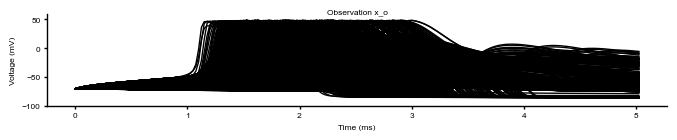

In [64]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 1.2))
    for i in range(len(x_o)):
        _ = ax.plot(time_vec, x_o[i], c="k")  #, c=cols[i])
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()